## Analyse Benchmark Testbed

In [35]:
%load_ext autoreload
import trafpy
import trafpy.generator as tpg

import os
import json
import glob
import pickle



# DATA_NAME = 'social_media_cloud_k_4_L_2_n_4_chancap500_numchans1_mldat2e6_bidirectional'
DATA_NAME = 'rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional'

# path_to_benchmark_data = '/scratch/datasets/trafpy/management/flowcentric/{}_testbed_data_v3.obj'.format(DATA_NAME)
path_to_testbed_data = '/scratch/datasets/trafpy/management/flowcentric/{}_slotsize_1000.0_testbed_data'.format(DATA_NAME)


if os.path.isdir(path_to_testbed_data):
    # data split into separate files in a directory
    separate_files = True
    # load paths to testbed data dirs
    testbed_data_list = sorted(glob.glob(path_to_testbed_data + '/*'))
    print(testbed_data_list)
    envs = []
    for testbed_path in testbed_data_list:
        try:
            filehandler = open(testbed_path+'/simulation.obj', 'rb')
            envs.append(pickle.load(filehandler))
        except FileNotFoundError:
            print('No simulation.obj in {}'.format(testbed_path))
        
else:
    # all data stored in single file
    separate_files = False
    # load raw testbed data
    filehandler = open(path_to_benchmark_data, 'rb')
    testbed_data = pickle.load(filehandler)
    print(testbed_data.keys())
    # unpack env dicts into list of env objects
    envs = testbed_data['envs']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.1_repeat_0_scheduler_FF', '/scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.1_repeat_0_scheduler_FS', '/scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.1_repeat_0_scheduler_Rand', '/scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.1_repeat_0_scheduler_SRPT', '/scratch/datasets/trafpy/management/flowcentric/rack_dist_

In [36]:
%autoreload
import trafpy
from trafpy.manager import EnvAnalyser, EnvsPlotter

import os

# analyse
analysers = [EnvAnalyser(env, time_units='\u03BCs', info_units='B', subject_class_name=env.scheduler.scheduler_name) for env in envs]
for analyser in analysers:
    env_analyser_database_path = path_to_testbed_data+'/'+analyser.env.sim_name
    analyser.compute_metrics(measurement_start_time='auto',
                             measurement_end_time='auto',
                             env_analyser_database_path=env_analyser_database_path,
                             overwrite=False,
                             print_summary=True)


Computing metrics for env benchmark_rack_load_0.1_repeat_0_scheduler_FF...
/scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.1_repeat_0_scheduler_FF/env_analyser_database exists and overwrite is False. Loading previously completed analysis...
Loaded previously saved analyser object from /scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.1_repeat_0_scheduler_FF/env_analyser_database in 0.4295477867126465 s.

-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_rack_load_0.1_repeat_0_scheduler_FF'
Measurement duration: 717295.5920252231 (Start time : 79699.51022502479 μs | End time: 796995.1022502478 μs)
Total number of generated demands (jobs or flows) passed to env: 137435
Total

Loaded previously saved analyser object from /scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.2_repeat_0_scheduler_FF/env_analyser_database in 0.3672504425048828 s.

-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_rack_load_0.2_repeat_0_scheduler_FF'
Measurement duration: 355923.31601250765 (Start time : 39547.03511250086 μs | End time: 395470.35112500854 μs)
Total number of generated demands (jobs or flows) passed to env: 137435
Total number of these demands which arrived during measurement period: 122997
Total info arrived: 2845312552.0 B
Total info transported: 2790730627.0 B
Load (abs): 7994.172969269627 B/μs
Load (frac): 0.19985432423174068 fraction of network capacity requested.
Throughput (abs): 7840.819922294525 B/μs
Throughput (frac): 0.9808168965614573 fraction of arrived info successfully trans

Loaded previously saved analyser object from /scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.3_repeat_0_scheduler_FF/env_analyser_database in 0.6329905986785889 s.

-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_rack_load_0.3_repeat_0_scheduler_FF'
Measurement duration: 459293.28029986215 (Start time : 51032.586699984684 μs | End time: 510325.8669998468 μs)
Total number of generated demands (jobs or flows) passed to env: 274870
Total number of these demands which arrived during measurement period: 248669
Total info arrived: 5585934431.0 B
Total info transported: 5469635029.0 B
Load (abs): 12162.020805863021 B/μs
Load (frac): 0.3040505201465755 fraction of network capacity requested.
Throughput (abs): 11908.806994583068 B/μs
Throughput (frac): 0.9791799557555529 fraction of arrived info successfully tran

Loaded previously saved analyser object from /scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.4_repeat_0_scheduler_FF/env_analyser_database in 0.78224778175354 s.

-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_rack_load_0.4_repeat_0_scheduler_FF'
Measurement duration: 346475.41987493436 (Start time : 38497.268874992704 μs | End time: 384972.68874992704 μs)
Total number of generated demands (jobs or flows) passed to env: 274870
Total number of these demands which arrived during measurement period: 246707
Total info arrived: 5509044130.0 B
Total info transported: 5342120851.0 B
Load (abs): 15900.245194849824 B/μs
Load (frac): 0.3975061298712456 fraction of network capacity requested.
Throughput (abs): 15418.46995359244 B/μs
Throughput (frac): 0.9697001376171587 fraction of arrived info successfully transp

Loaded previously saved analyser object from /scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.5_repeat_0_scheduler_FF/env_analyser_database in 1.3522837162017822 s.

-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_rack_load_0.5_repeat_0_scheduler_FF'
Measurement duration: 550951.7007599514 (Start time : 61216.8556399946 μs | End time: 612168.556399946 μs)
Total number of generated demands (jobs or flows) passed to env: 549740
Total number of these demands which arrived during measurement period: 493502
Total info arrived: 10917987888.0 B
Total info transported: 10708471021.0 B
Load (abs): 19816.59712265222 B/μs
Load (frac): 0.4954149280663055 fraction of network capacity requested.
Throughput (abs): 19436.315390676435 B/μs
Throughput (frac): 0.9808099377697349 fraction of arrived info successfully transpo

Loaded previously saved analyser object from /scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.6_repeat_0_scheduler_FF/env_analyser_database in 1.4921071529388428 s.

-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_rack_load_0.6_repeat_0_scheduler_FF'
Measurement duration: 476846.02635013504 (Start time : 52982.89181668167 μs | End time: 529828.9181668167 μs)
Total number of generated demands (jobs or flows) passed to env: 549740
Total number of these demands which arrived during measurement period: 492299
Total info arrived: 11383944362.0 B
Total info transported: 11078292620.0 B
Load (abs): 23873.417692362356 B/μs
Load (frac): 0.5968354423090589 fraction of network capacity requested.
Throughput (abs): 23232.43145129097 B/μs
Throughput (frac): 0.9731506293178772 fraction of arrived info successfully tran

Loaded previously saved analyser object from /scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.7_repeat_0_scheduler_FF/env_analyser_database in 1.0290837287902832 s.

-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_rack_load_0.7_repeat_0_scheduler_FF'
Measurement duration: 417813.1875000155 (Start time : 46423.68750000172 μs | End time: 464236.8750000172 μs)
Total number of generated demands (jobs or flows) passed to env: 549740
Total number of these demands which arrived during measurement period: 494017
Total info arrived: 11702137554.0 B
Total info transported: 10925724975.0 B
Load (abs): 28008.06174649422 B/μs
Load (frac): 0.7002015436623554 fraction of network capacity requested.
Throughput (abs): 26149.78488442181 B/μs
Throughput (frac): 0.9336520720751049 fraction of arrived info successfully transp

Loaded previously saved analyser object from /scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.8_repeat_0_scheduler_FF/env_analyser_database in 1.3695013523101807 s.

-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_rack_load_0.8_repeat_0_scheduler_FF'
Measurement duration: 361430.38912488514 (Start time : 40158.932124987245 μs | End time: 401589.3212498724 μs)
Total number of generated demands (jobs or flows) passed to env: 549740
Total number of these demands which arrived during measurement period: 493712
Total info arrived: 11536713470.0 B
Total info transported: 10291949323.0 B
Load (abs): 31919.60005890295 B/μs
Load (frac): 0.7979900014725737 fraction of network capacity requested.
Throughput (abs): 28475.605905522847 B/μs
Throughput (frac): 0.8921040944427651 fraction of arrived info successfully tra

Loaded previously saved analyser object from /scratch/datasets/trafpy/management/flowcentric/rack_dist_sensitivity_0.8_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional_slotsize_1000.0_testbed_data/benchmark_rack_load_0.9_repeat_0_scheduler_FF/env_analyser_database in 1.1307685375213623 s.

-=-=-=-=-=-=--= Summary -=-=-=-=-=-=-=-

 ~* General Information *~
Simulation name: 'benchmark_rack_load_0.9_repeat_0_scheduler_FF'
Measurement duration: 309180.3312000423 (Start time : 34353.37013333803 μs | End time: 343533.7013333803 μs)
Total number of generated demands (jobs or flows) passed to env: 549740
Total number of these demands which arrived during measurement period: 496046
Total info arrived: 11267121834.0 B
Total info transported: 9351326733.0 B
Load (abs): 36441.910099093846 B/μs
Load (frac): 0.9110477524773462 fraction of network capacity requested.
Throughput (abs): 30245.54212974697 B/μs
Throughput (frac): 0.829965883991878 fraction of arrived info successfully transpo

,Load,Subject,T-Score,Mean FCT (μs),p99 FCT (μs),Max FCT (μs),Throughput Frac,Frac Flows Dropped,Frac Info Dropped
0,0.10,FS,-310.668851,1524.8,1997.1,42431.4,0.992984,0.00155,0.00702
1,0.10,SRPT,-318.919251,1524.2,1997.4,43431.4,0.993195,0.00159,0.00681
2,0.10,Rand,-320.682982,1554.6,2802.1,62523.4,0.992885,0.00160,0.00712
3,0.10,FF,-327.281918,1571.7,3260.5,40431.4,0.993247,0.00163,0.00675
4,0.20,FS,-570.514507,1518.6,1999.0,33140.6,0.981506,0.00284,0.01850
5,0.20,SRPT,-573.784865,1520.5,2289.7,34140.6,0.981779,0.00285,0.01820
6,0.20,Rand,-641.133137,1579.4,3131.5,122062.8,0.972588,0.00319,0.02740
7,0.20,FF,-714.887585,1643.2,4960.0,37062.8,0.980817,0.00355,0.01920
8,0.30,FS,-531.062854,1532.6,2163.4,56032.7,0.981807,0.00264,0.01820
9,0.30,SRPT,-548.895960,1542.6,2698.0,61032.7,0.982468,0.00273,0.01750


,Load,Mean FCT (μs),p99 FCT (μs),Max FCT (μs),Throughput Frac,Frac Flows Dropped,Frac Info Dropped
0,0.10,SRPT,FS,FF,FF,FS,FF
1,0.20,FS,FS,FS,SRPT,FS,SRPT
2,0.30,FS,FS,FS,SRPT,FS,SRPT
3,0.40,FS,FS,FS,SRPT,FS,SRPT
4,0.50,FS,FS,FS,FS,FS,FS
5,0.60,FS,FS,FS,FS,FS,FS
6,0.70,FS,SRPT,FS,FS,FS,FS
7,0.80,FS,SRPT,FF,FS,FS,FS
8,0.91,FS,SRPT,FF,FF,FS,FF


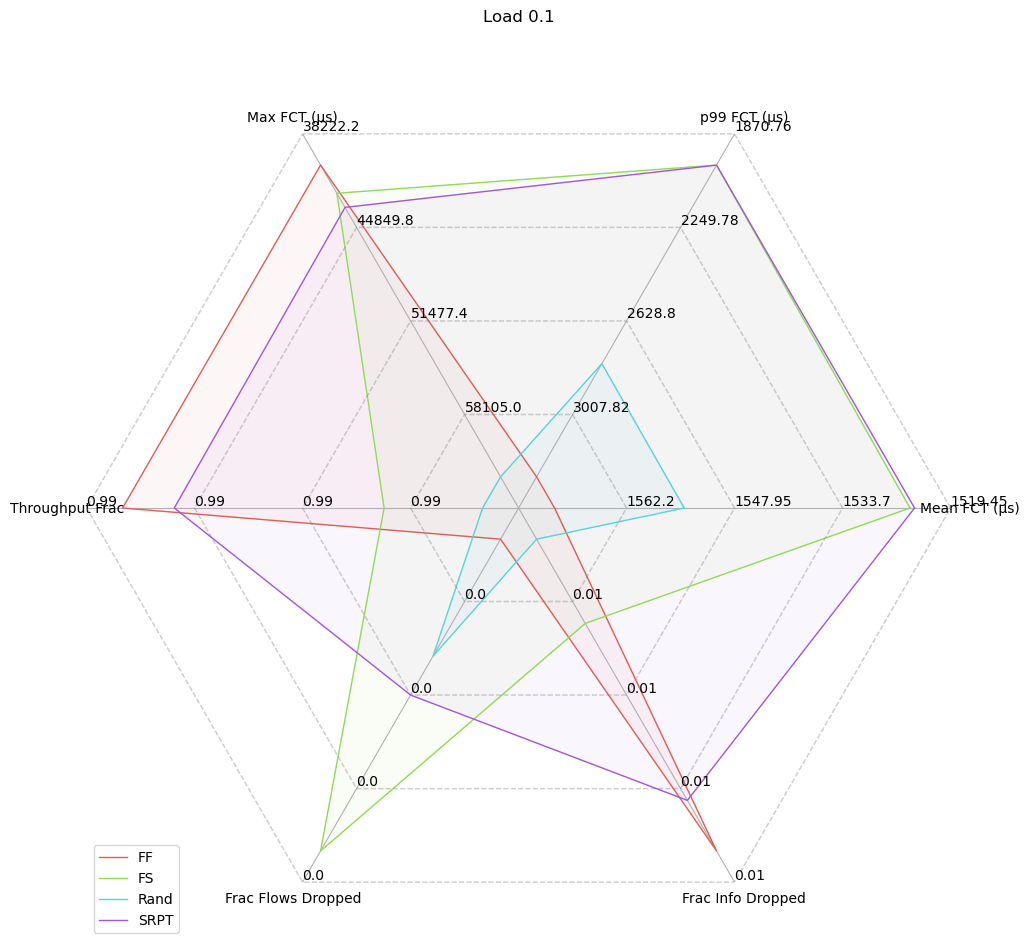

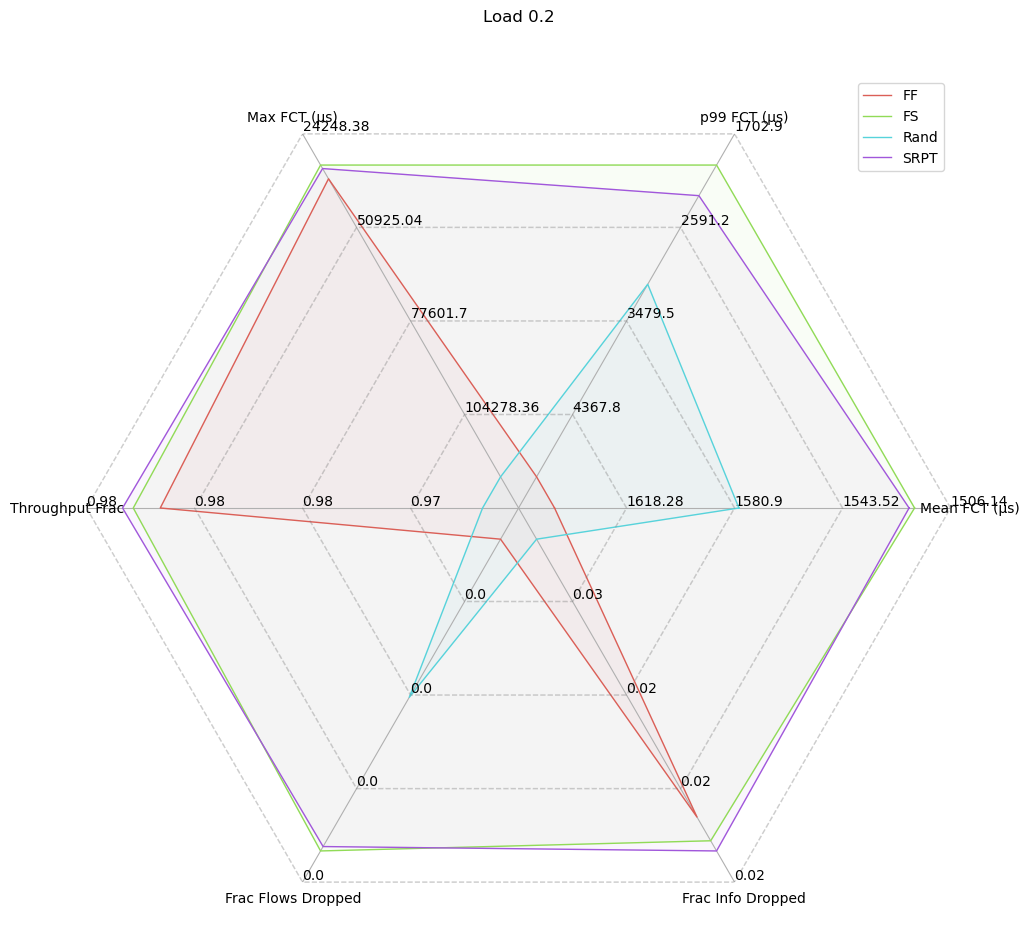

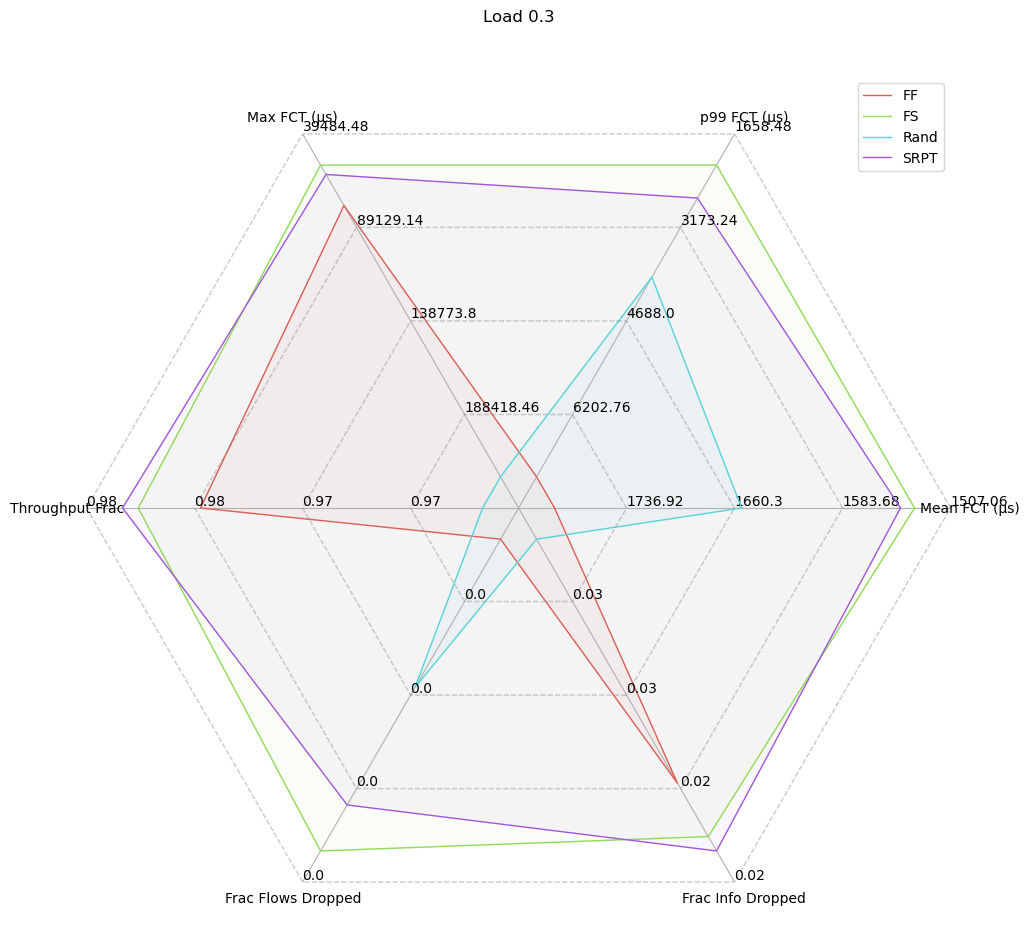

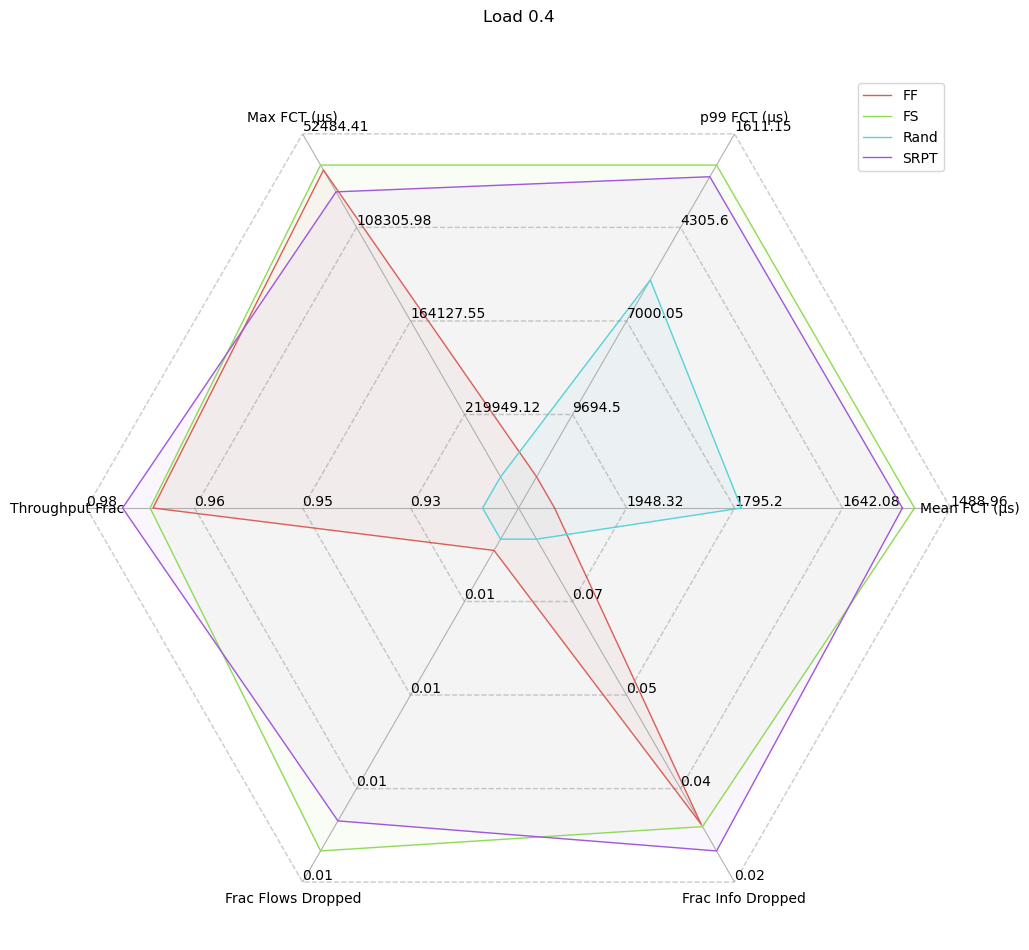

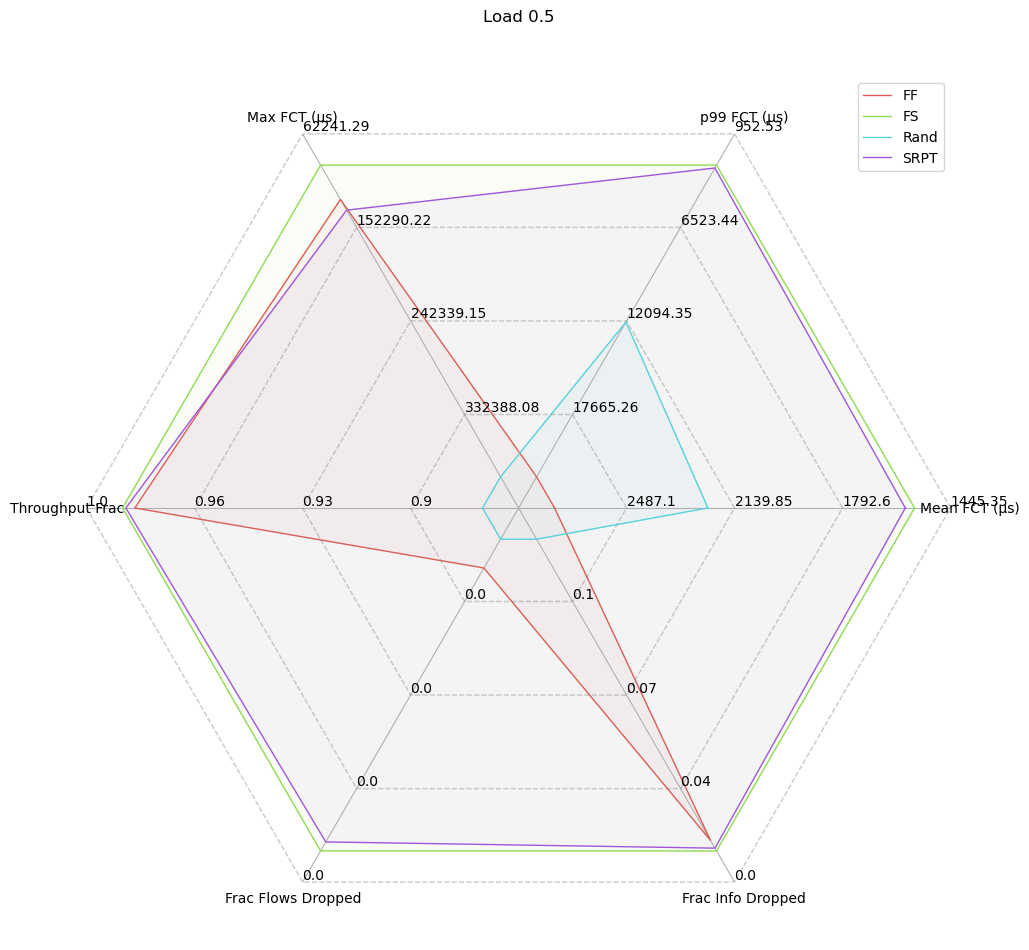

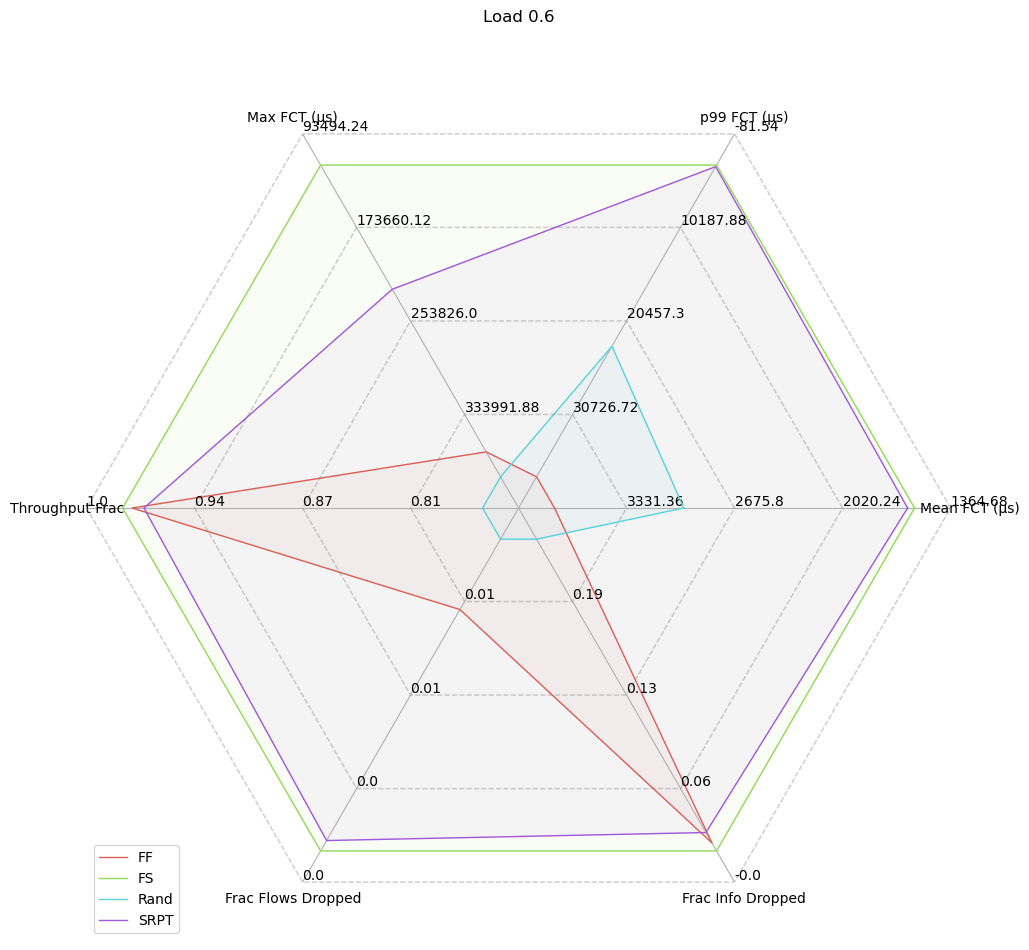

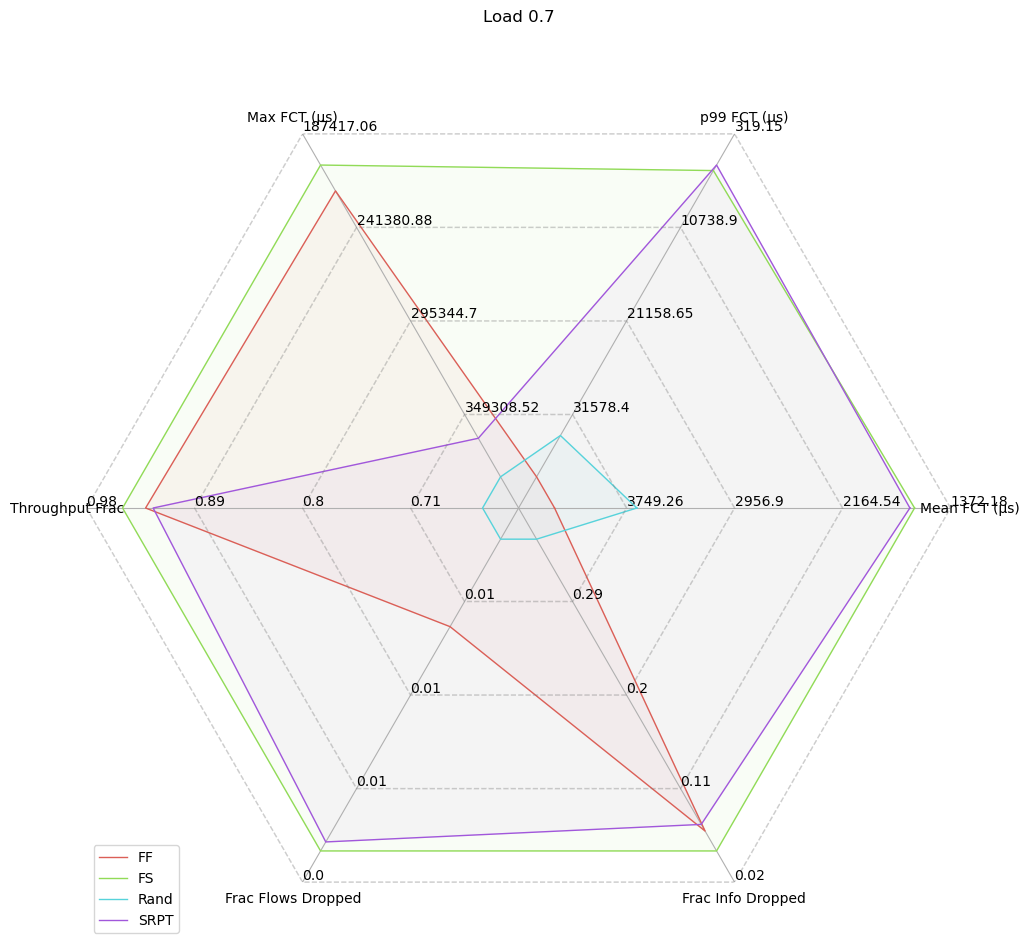

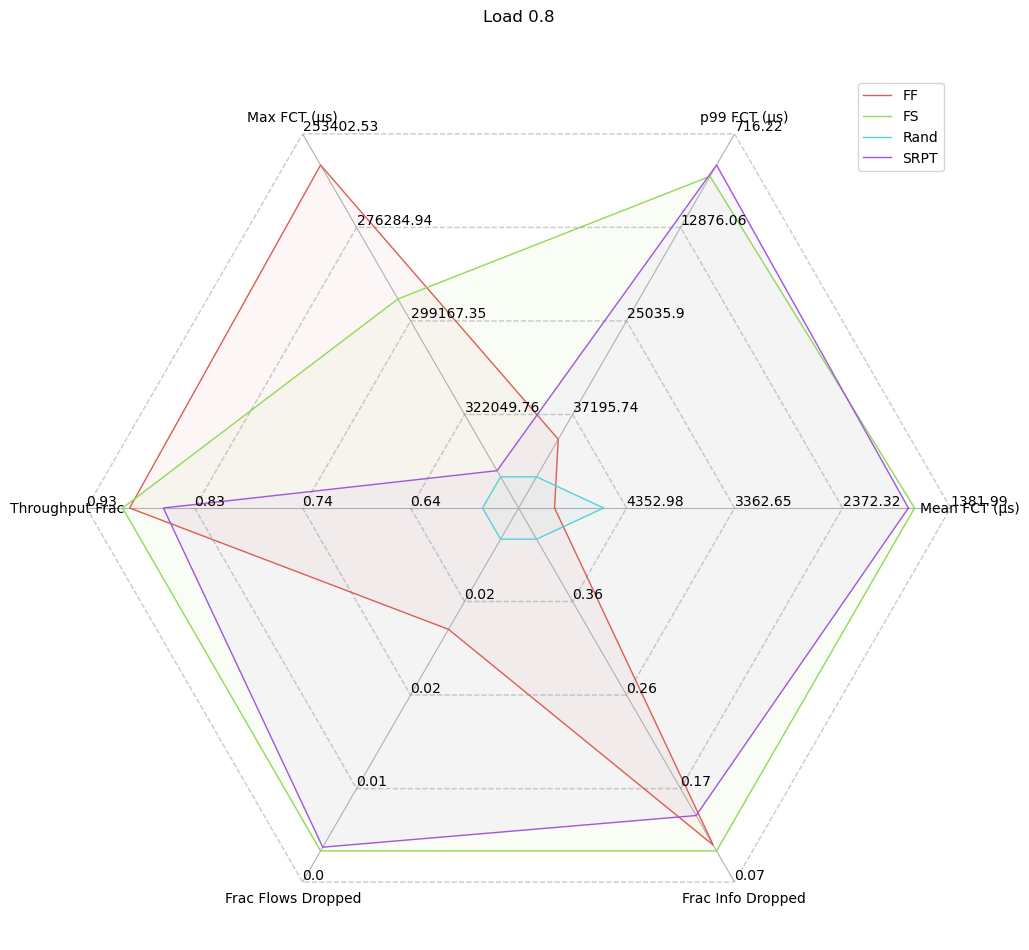

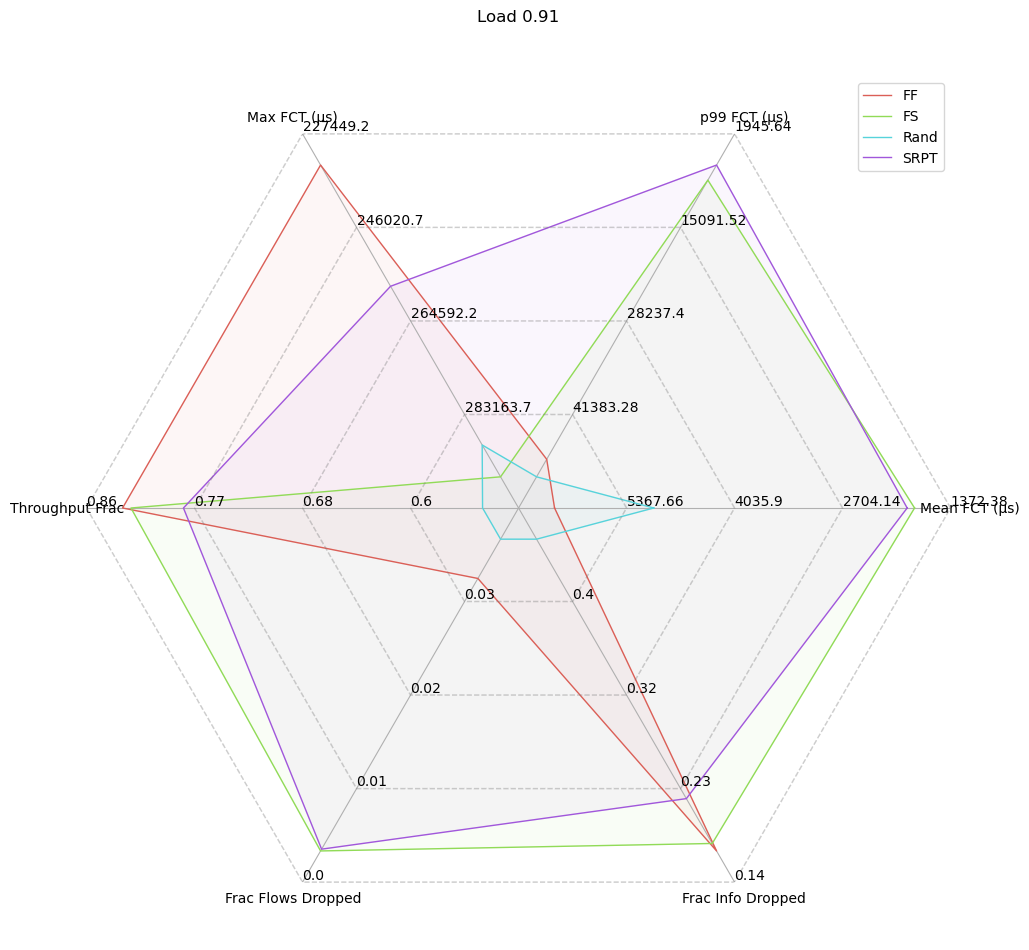

Exception: 

In [37]:
%autoreload
import trafpy
from trafpy.manager import EnvAnalyser, EnvsPlotter

import time


start = time.time()
    
# plot
plotter = EnvsPlotter(time_units='\u03BCs', info_units='B')
_ = plotter.display_t_score_table(*analysers, display_table=True)
raise Exception()
# _ = plotter.plot_t_score_scatter(*analysers, gridlines=True, figsize=(4, 3), legend_ncol=2)

# COMMENT IF HAVEN'T TRACKED QUEUE EVOLUTION AND SCHEDULER DECISION COLOUR GRID
# _ = plotter.plot_src_dst_queue_evolution_for_different_loads('server_2', 'server_10', 'queue_lengths_num_flows', *analysers)
# _ = plotter.plot_src_dst_queue_evolution_for_different_loads('server_2', 'server_10', 'queue_lengths_info_units', *analysers)
# _ = plotter.plot_demand_slot_colour_grid_for_different_schedulers(*analysers)

# COMMENT IF WANT TO SAVE TIME
# _ = plotter.plot_link_utilisation_vs_time_for_different_loads(*analysers, mean_period=10, figsize=(6, 2), legend_ncol=2, plot_legend=False) # mean_period=2500
# _ = plotter.plot_link_concurrent_demands_vs_time_for_different_loads(*analysers, mean_period=500)




_ = plotter.plot_demand_completion_time_vs_size_for_different_loads(*analysers, gridlines=True, figsize=(4, 3), legend_ncol=2)
_ = plotter.plot_throughput_rate_vs_load(*analysers, plot_bar_charts=False, gridlines=True, figsize=(6, 2), legend_ncol=2)
_ = plotter.plot_throughput_frac_vs_load(*analysers, plot_bar_charts=False, gridlines=True, figsize=(6, 2), legend_ncol=2)
_ = plotter.plot_fcts_cdf_for_different_loads(*analysers, gridlines=True, figsize=(6, 2), legend_ncol=2)
_ = plotter.plot_mean_fct_vs_load(*analysers, logscale=True, gridlines=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)
_ = plotter.plot_99th_percentile_fct_vs_load(*analysers, logscale=True, gridlines=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)
_ = plotter.plot_max_fct_vs_load(*analysers, gridlines=True, logscale=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)
_ = plotter.plot_fraction_of_arrived_flows_dropped_vs_load(*analysers, logscale=True, gridlines=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)
_ = plotter.plot_fraction_of_arrived_info_dropped_vs_load(*analysers, logscale=True, gridlines=True, cdf_figsize=(6, 2), scatter_figsize=(4,3), legend_ncol=2)

end = time.time()
print('Time to plot: {}'.format(end-start))

In [ ]:
# CUSTOM RADAR PLOT(S)
%load_ext autoreload
%autoreload
import trafpy.generator as tpg

time_units = '\u03BCs'
info_units = 'B'

plot_dict = {'Mean FCT ({})'.format(time_units): {'range': [0, 1], 'classes': {'class1': 0.2,
                                                         'class2': 0.4}},
             'p99 FCT ({})'.format(time_units): {'range': [0, 100], 'classes': {'class1': 60,
                                                           'class2': 20}},
             'Max FCT ({})'.format(time_units): {'range': [1, 5], 'classes': {'class1': 2,
                                                         'class2': 5}},
             'Throughput Rate ({}/{})'.format(info_units, time_units): {'range': [0, 10], 'classes': {'class1': 7,
                                                          'class2': 3}},
             'Frac Info Dropped': {'range': [0, 10], 'classes': {'class1': 7,
                                                          'class2': 3}},
             'Frac Flows Dropped': {'range': [10, 0], 'classes': {'class1': 1,
                                                          'class2': 2}}
            }

_ = tpg.plot_radar(plot_dict)

# Custom Plots

In [ ]:
# PLOT SCHEDULER SENSITIVITY TO LOAD
%load_ext autoreload
%autoreload
import trafpy.generator as tpg

from collections import defaultdict
import sigfig


def get_summary_dict(analysers, headers, time_units='', info_units=''):
    summary_dict = {header: [] for header in headers}
    for analyser in analysers:
        # self._check_analyser_valid(analyser)
        summary_dict['Load'].append(round(analyser.load_frac, 2))
        summary_dict['Subject'].append(analyser.subject_class_name)
        summary_dict['T-Score'].append(analyser.t_score)
        summary_dict['Mean FCT ({})'.format(time_units)].append(round(analyser.mean_fct, 1))
        summary_dict['p99 FCT ({})'.format(time_units)].append(round(analyser.nn_fct, 1))
        summary_dict['Max FCT ({})'.format(time_units)].append(round(analyser.max_fct, 1))
        summary_dict['Throughput Frac'].append(round(analyser.throughput_frac, 1))
        summary_dict['Frac Flows Dropped'].append(sigfig.round(analyser.dropped_flow_frac, sigfigs=3))
        summary_dict['Frac Info Dropped'].append(sigfig.round(analyser.dropped_info_frac, sigfigs=3))
    return summary_dict



time_units = '\u03BCs'
info_units = 'B'
headers = ['Load',
           'T-Score',
           'Subject',
           'Mean FCT ({})'.format(time_units),
           'p99 FCT ({})'.format(time_units),
           'Max FCT ({})'.format(time_units),
           'Throughput Frac',
           'Frac Info Dropped',
           'Frac Flows Dropped']
dont_plot_headers = ['Load', 'T-Score', 'Subject']
plot_headers = [header for header in headers if header not in dont_plot_headers]
# determine if higher is better for each header
is_higher_better = {}
for header in headers:
    if header == 'T-Score' or header == 'Throughput Frac':
        is_higher_better[header] = True
    else:
        is_higher_better[header] = False

scheduler_to_analysers = {}
for analyser in analysers:
    if analyser.env.scheduler.scheduler_name not in scheduler_to_analysers:
        scheduler_to_analysers[analyser.env.scheduler.scheduler_name] = [analyser]
    else:
        scheduler_to_analysers[analyser.env.scheduler.scheduler_name].append(analyser)

for scheduler_name in scheduler_to_analysers.keys():
    nested_dict = lambda: defaultdict(nested_dict)
    plot_dict = nested_dict()
    
    anys = scheduler_to_analysers[scheduler_name]
    summary_dict = get_summary_dict(anys, headers, time_units=time_units, info_units=info_units)
    
    for header in plot_headers:
        min_val, max_val = min(summary_dict[header]), max(summary_dict[header])
        
#         if is_higher_better[header]:
#             # want higher (better) values on outer radar edge -> don't flip range
#             _range = [0.9*min(summary_dict[header]), 1.1*max(summary_dict[header])]
#         else:
#             # want lower (better) values on outer radar edge -> flip range
#             _range = [1.1*max(summary_dict[header]), 0.9*min(summary_dict[header])]
            
        diff = max(max_val - min_val, 1e-9)
        min_val -= (0.1*diff)
        max_val += (0.1*diff)
        _range = [min_val, max_val]
#         _range = [max(min_val, 1e-9), max(max_val, 1e-9)]
        if not is_higher_better[header]:
            # flip axis
            _range = _range[::-1]

        plot_dict[header]['range'] = _range
        for i, load in enumerate(summary_dict['Load']):
            plot_dict[header]['classes']['Load {}'.format(str(load))] = summary_dict[header][i]
        
    tpg.plot_radar(plot_dict, 
                   title=scheduler_name,
                   fill=True,
                   fill_alpha=0.05,
                   figsize=(12.8, 9.6))
        
    

In [ ]:
# %autoreload
# import trafpy
# import trafpy.generator as tpg
# from trafpy.manager import RandomAgent, RWA, Demand, DCN, EnvAnalyser
# import json

# DATA_BAME = 'artificial_light_chancap10'
# path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/benchmark_data/{}_benchmark_data.json'.format(DATA_NAME)
# benchmark_data = json.loads(tpg.load_data_from_json(path_to_benchmark_data))
# benchmarks = list(benchmark_data.keys())

# SLOT_SIZE = 1.0
# PACKET_SIZE = 1
# NUM_CHANNELS = 1
# NUM_K_PATHS = 1
# MAX_FLOWS = 10
# MAX_TIME = None

In [ ]:
# network = tpg.gen_fat_tree(k=3, N=2, num_channels=1, server_to_rack_channel_capacity=10)
# rwa = RWA(tpg.gen_channel_names(NUM_CHANNELS), NUM_K_PATHS)
# scheduler = RandomAgent(network, rwa, slot_size=SLOT_SIZE, packet_size=PACKET_SIZE)

# num_benchmark_tests = 0
# for benchmark in benchmarks:
#     for load in benchmark_data[benchmark]:
#         for repeat in benchmark_data[benchmark][load]:
#             num_benchmark_tests += 1

# for benchmark in benchmarks:
#     for load in list(benchmark_data[benchmark].keys()):
#         for repeat in benchmark_data[benchmark][load]:
#             if json.loads(load) == 0.1 and scheduler.scheduler_name == 'random':
#                 demand_data = benchmark_data[benchmark][load][repeat]
#                 demand = tpg.Demand(demand_data)
#                 env = DCN(network, demand, scheduler, num_k_paths=NUM_K_PATHS, slot_size=SLOT_SIZE, max_flows=MAX_FLOWS, max_time=MAX_TIME)
#                 print(env.slot_size)
                
#                 observation = env.reset()
#                 scheduler.register_env(env)
                
#                 while True:
#                     action = scheduler.get_action(observation)
#                     observation, reward, done, info = env.step(action)
                    
#                     if done:
#                         print('Completed')
#                         analyser = EnvAnalyser(env)
#                         analyser.compute_metrics(print_summary=True)

In [ ]:
# packet size = info
# slot size = sec
# min bandwidth in network = info per sec

# assume that 1 packet size of info can be transferred per sub slot
# info per sub slot = 1 packet = packet size
# sub slot size = (info per sub slot / min bandwidth in network) * slot size

In [ ]:
a = None
if a is not None:
    print('not none')
else:
    print('None')

In [ ]:
increment_time = 1.001
print(round(1-(increment_time-1),6))

In [ ]:
ep_link_capacity = 500
